# Stochastic chemical reactions 

Biological processes take place in relatively small volumes, within cells and subcellular compartments. They involve molecules, which come in discrete, integral and often small numbers, and can generally undergo multiple types of transformations. This leads to some degree of stochasticity in the trajectory of the system, and sometimes to  qualitatively different dynamics than the dynamics predicted with deterministic differential equations, as done in  classical chemical kinetics analyses.

Analyses of stochasticity and its control in biological systems have gained a new impetus from about the beginning of the years 2000, due to a variety of factors among which experiments that demonstrated, quantified, and identified sources of noise in [bacterial](https://www.science.org/doi/10.1126/science.1070919) and [eukaryotic](https://www.science.org/doi/10.1126/science.1098641) cells. 

Interestingly, around the same time the small RNAs known as [microRNAs](https://www.nature.com/articles/35002607) (miRNAs) were discovered, and immediately implicated in [developmental robustness](https://www.nature.com/articles/ng1803) by means of suppressing noise in gene regulatory networks. Further work in the field uncovered a type of genetic circuit that occurs frequently in gene regulatory networks and can buffer stochastic fluctuations in gene expression. This circuit is composed of a transcriptional regulator (transcription factor, TF), a post-transcriptional regulator (miRNA) and a target (protein-coding) gene, and it looks like this

![Incoherent feed-forward loop](FFL.png)

That is, the TF induces the expression of miRNA and protein-coding gene, while the miRNA induces the degradation of the protein-coding gene's mRNA, thereby repressing its expression. Thus, the protein-coding gene experience two contradictory regulatory influences, one positive and the other negative, which is why the circuit is called **incoherent feed-forward loop**. Its dynamics has been [analyzed](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001101) and it is summarized in the figure below, alongside with the stochastic dynamics of a network that does not contain the miRNA.

![Incoherent feed-forward loop dynamics](FFL_dynamics.png)

- $s$ is the miRNA, 
- $q$ is the transcription factor protein, 
- $r$ is the target mRNA, 
- $p$ is the target protein.

The $y$-axis of the plots shows the fluctuations of various quantities around their respective means, in two regulatory scenarios, namely the incoherent FFL (iFFL, top) and the linear TF-target network. In the linear network, the target mRNA $r$ and protein $p$ follow reasonably well the fluctuations in the transcription factor $q$, which induces their expression. In the iFFl, the miRNA $s$ and target mRNA $r$ also follow the TF, while the target protein does not. Furthermore, the fluctuations in the target protein level $q$ are smaller when the target is regulated in an iFFL (top plot) compared to being regulated solely at the level of transcription (bottom plot).

We can study the trajectory of target protein abundance in function of its regulatory circuit using stochastic simulations. Efficient algorithms for computing [statistically correct trajectories](https://en.wikipedia.org/wiki/Gillespie_algorithm) of biochemical systems have been introduced since the 1940's, in particular by the very influential work of [Daniel Gillespie](https://www.annualreviews.org/content/journals/10.1146/annurev.physchem.58.032806.104637). Let us illustrate the algorithm on a very simple system of a reversible dimerization reaction involving two monomers, **A** and **B**. The reactions then are:

$$ {\bf A} + {\bf B} \xrightarrow{r_f} {\bf AB}$$

$$ {\bf AB} \xrightarrow{r_b} {\bf A} + {\bf B}$$
If we denote the number of molecules of each type by $N_A, N_B, N_{AB}$, then the rate of the forward (dimerization) reaction is $r_f N_A N_B$, the rate of the backward (dissociation) reaction is $r_b N_{AB}$ and the rate of any reaction occurring is $R = r_f N_A N_B + r_b N_{AB}$. We then assume that reactions follow a Poisson process, the waiting time to the next reaction being exponentially distributed with rate $R$: $P(t) = R e^{-Rt}$. The mean waiting time would be $\frac{1}{R}$. Note that as reactions take place and the numbers of molecules fluctuate, $R$ also varies in time.

Assuming a reaction did occur, the probability of it being the dimerization is given by
$P({\bf A} + {\bf B} \rightarrow {\bf AB}) = \frac{r_f N_A N_B}{R}$ while the probability of it being the dissociation is given by $P({\bf AB} \rightarrow {\bf A} + {\bf B}) = \frac{r_b N_{AB}}{R}$ So, to simulate this system we can repeat the following steps:

1. Given current numbers of molecules calculate the rate of individual reactions and the total rate $R$
2. Determine the time to the next reaction - sample from the exponential distribution with rate $R$
3. Determine which reaction takes place - sample reaction in proportion to its relative rate
4. Update molecular species involved in the sampled reaction and update the time

We have a few more details to sort out, namely how we pick the time and the reaction that takes place at a given step. First, picking which reaction should take place: it is quite intuitive to see that if we view the rates of the reactions as segments of corresponding lengths, line up all the segments next to each other into an interval, and then, when we want to sample reactions, we blindly pick points in the interval (*using the numpy.random.random()* method, which gives us values distributed uniformly in the [0,1] interval), the fraction of times we will land in the segment corresponding to a particular reaction is given by the relative length of that segment in the interval (see figure below).

![Sampling in proportion to probability](uniform_sampling.png)

To sample from the exponential distribution to determine the time to the next reaction we use again the uniform distribution and another trick. Let's say we have the random variable $u$ distributed uniformly in the [0,1] interval. That is, $$0 \leq u \leq 1, P(u) = 1$$. What is the distribution of $$X = -\log(U)$$? If we write the cumulative distribution of $X$ 
$$F_X(x) = P(X \leq x) = P(-log(U) \leq x)$$ and note that
$$ -\log(U) \leq x \Rightarrow \log(U) \geq -x \Rightarrow U \geq e^{-x}$$
Then 
$$ P(-log(U) \leq x) = P(U \geq e^{-x}) = 1 - P(U \leq e^{-x}) = 1 - F_U(e^{-x})$$
where $F_U(e^{-x})$ is the cumulative of the uniform distribution evaluated $e^{-x}$.
But $F_U(e^{-x}) = e^{-x}$ for $0 \leq e^{-x} \leq 1, x \geq 1$, which means that $$F_X(x) = 1 - e^{-x}$$
Differentiating with respect to $x$, we get that the probability density function of $X$ is 
$$f_x(x) = \frac{d}{dx} F_X(x) = \frac{d}{dx} \left(1 - e^{-x}\right) = e^{-x}$$
This is the probability density function of the exponential, with rate parameter $\lambda = 1$. Thus, to sample from the exponential distribution, we sample a value $u$ from the uniform distribution and transform it to $-\log(u)$. To sample from an exponential with $\lambda \neq 1$, we multiply the value obtained as described by the rate $\lambda$. Note that the rate of exponential and the rates of our reactions are entirely different things. We deal with exponentially-distributed *time* to next reaction, so the rate of the exponential distribution is the mean time to next reaction, $\overline{t}$. This, in turn, is $\overline{t} = \frac{1}{R},$ with $R$ being the total rate of all reactions.

Below is an implementation of the Gillespie algorithm for the reversible dimerization described above.


Matplotlib is building the font cache; this may take a moment.


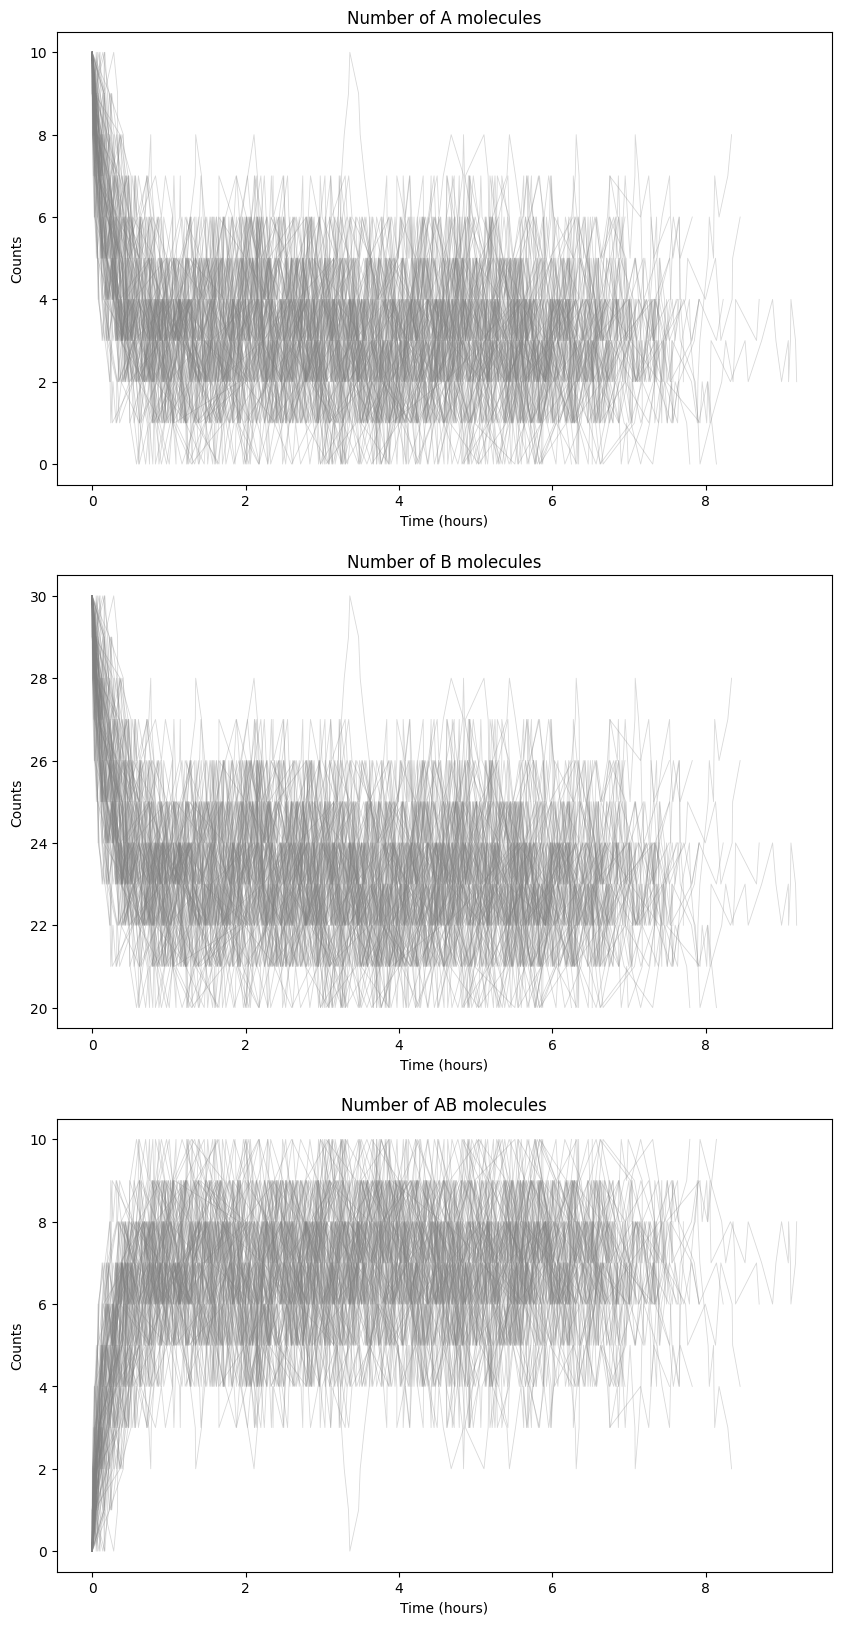

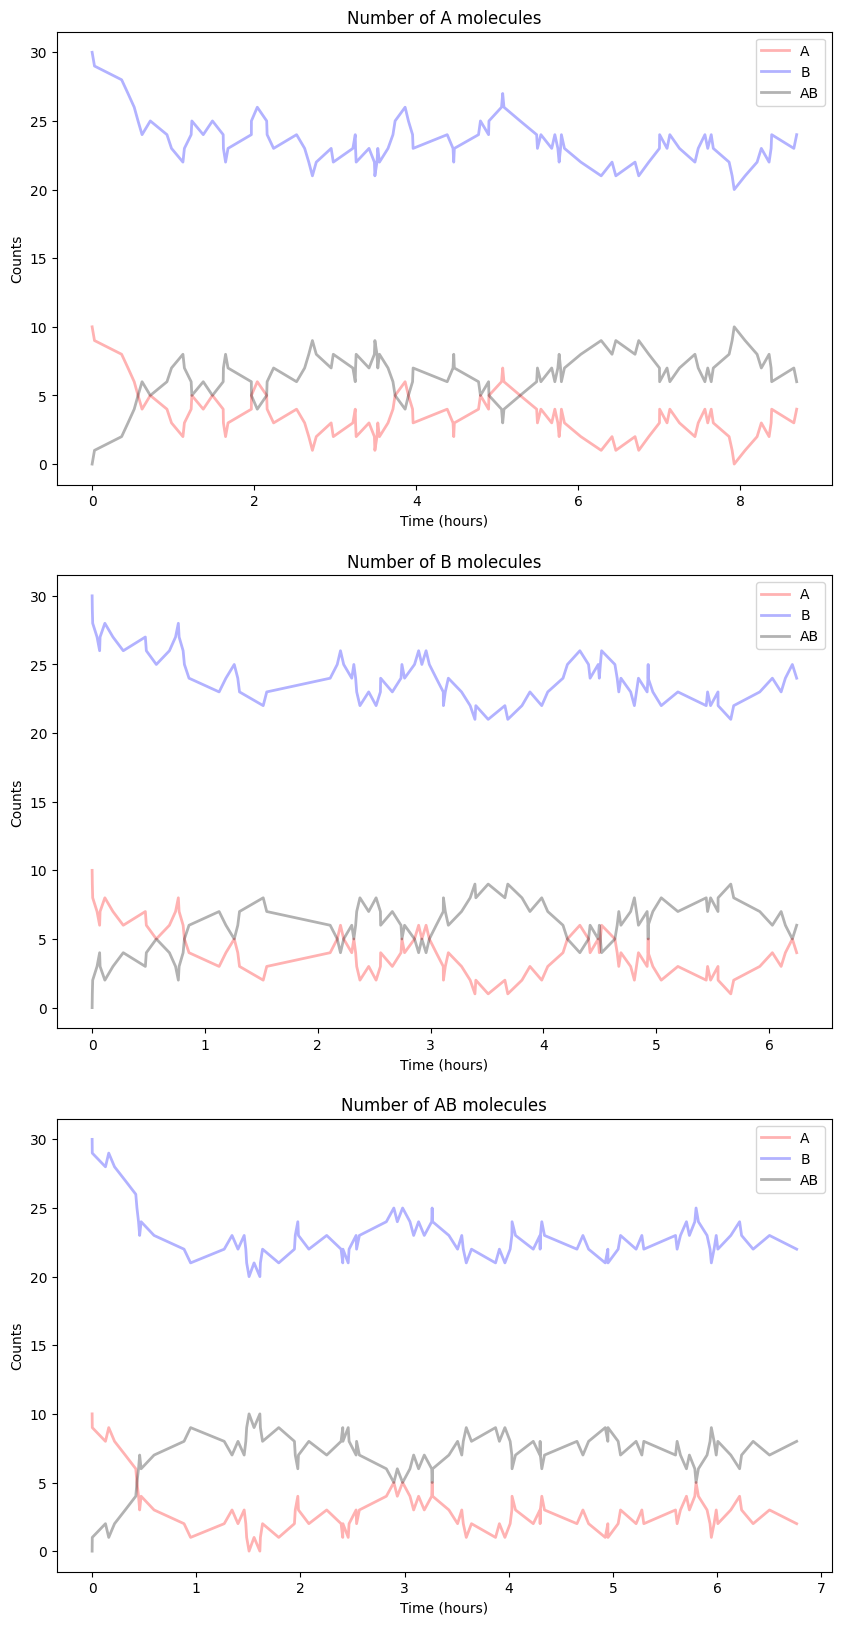

In [3]:
# Reactions:
# A + B -> AB
# AB -> A + B

# Molecular counts
# N_A
# N_B
# N_AB

# Reaction rates
# rf : reaction rate for A + B -> AB
# rb : reaction rate for AB -> A + B

# Import supporting packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the random number seed for reproducibility
np.random.seed(1)

# Set reaction rates 
rf = 0.1        # Forward reaction rate
rb = 1.0        # Backwards reaction rate

# Set meta-parameters
steps = 100          # Number of reactions per trajectory
trajectories = 100  # Number of trajectories to simulate

# Set up data arrays
T = np.zeros((trajectories, steps+1))
N_A = np.zeros((trajectories, steps+1))
N_B = np.zeros((trajectories, steps+1))
N_AB = np.zeros((trajectories, steps+1))

# Set initial conditions
T[:,0] = 0 # for completeness
N_A[:,0] = 10
N_B[:,0] = 30
N_AB[:,0] = 0

# Run simulation
for i in range(trajectories):
    for j in range(steps):
        # Calculate current total reaction rate
        R = rf * N_A[i,j] * N_B[i,j] + rb * N_AB[i,j]
        
        # Calculate and store time to next reaction
        u = np.random.random()
        t = 1/R * np.log(1/u)
        T[i, j+1] = T[i,j] + t
        
        # Select next reaction
        pf = rf * N_A[i,j] * N_B[i,j] / R # probability of forward reaction
        u = np.random.random()
        
        # Apply the reaction
        if u < pf:
            # selected forward reaction
            N_A[i,j+1] = N_A[i,j] - 1
            N_B[i,j+1] = N_B[i,j] - 1
            N_AB[i,j+1] = N_AB[i,j] + 1
        else:
            # selected backward reaction
            N_A[i,j+1] = N_A[i,j] + 1
            N_B[i,j+1] = N_B[i,j] + 1
            N_AB[i,j+1] = N_AB[i,j] - 1


# Plot the simulated trajectories for each molecule type
fig, axs = plt.subplots(3, 1, figsize=(10,20))

molecule_type = ['A', 'B', "AB"]
for i in range(3):
    axs[i].set_title(f'Number of {molecule_type[i]} molecules')
    axs[i].set_xlabel("Time (hours)")
    axs[i].set_ylabel("Counts")
    
# Plot each simulated trajectory
for i in range(trajectories):
    axs[0].plot(T[i,:], N_A[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(T[i,:], N_B[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(T[i,:], N_AB[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

# Let's also plot a few simulations
n2plot = 3
is2plot = np.random.choice(list(range(trajectories)), size=n2plot, replace=False)
fig, axs = plt.subplots(n2plot, 1, figsize=(10,20))

for i in range(n2plot):
    axs[i].set_title(f'Number of {molecule_type[i]} molecules')
    axs[i].set_xlabel("Time (hours)")
    axs[i].set_ylabel("Counts")
    axs[i].plot(T[i,:], N_A[i,:], marker='', color='red', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N_B[i,:], marker='', color='blue', linewidth=2.0, alpha=0.3)
    axs[i].plot(T[i,:], N_AB[i,:], marker='', color='black', linewidth=2.0, alpha=0.3)
    axs[i].legend(molecule_type)
plt.show()

## Goal of this project
Write the code for a Gillespie simulation of the miRNA-TF-target protein FFL. The reactions you will need to include are:
- TF transcription (at a constant rate $\alpha_T$)
- TF translation into protein at rate $\pi_T$ per TF mRNA
- decay of the TF mRNA at rate $\mu_T$
- decay of the TF protein at rate $\mu_Q$
- miRNA production at rate $\alpha_S(q) = \alpha_S \frac{q}{q+K_S}$
- miRNA decay at rate $\mu_S$
- target mRNA transcription at rate $\alpha_R(Q) = \alpha_R \frac{q}{q+K_R}$
- target mRNA decay at rate $\mu_R$
- target protein production at rate $\pi_R$ per mRNA
- target protein decay at rate $\mu_R$
- free target mRNA binds the miRNA at rate $\beta$ to make a mRNA-miRNA complex
- mRNA-miRNA complex falls apart at rate $\mu_C$, with the mRNA being lost and the miRNA recycled. 